| Column  | Description  |
| :------------: | :------------: |
| ID  | unique identifier  |
| Gender  | "Male", "Female" or "Other"  |
| Age  |  age of the patient  |
| hypertension  |  0 if the patient doesn't have hypertension, 1 if the patient has hypertension  |
|  heart_disease  | 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease  |
|  ever_married  | "No" or "Yes"  |
|  work_type  |  "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"  |
| Residence_type  |  "Rural" or "Urban"  |
|  avg_glucose_level  | average glucose level in blood  |
|  bmi  | body mass index  |
| smoking_status  | "formerly smoked", "never smoked", "smokes" or "Unknown"*  |
|  stroke  | 1 if the patient had a stroke or 0 if not  |


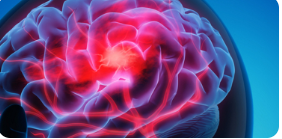

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pca import pca
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.dummy import DummyClassifier

from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
def col_distribution(data_frame, col):
    """
    this method takes 2 parameters
    data_frame : the name of the data frame
    col : column which you want to show its distribution
    
    return : 2 plots (histplot and boxplot to show distribution and outliers)
    """
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    sns.histplot(data=data_frame, x=col, ax=ax[0])
    ax[0].set_title(f'{col.upper()} Distribution')

    sns.boxplot(data=data_frame, x=col, ax=ax[1])
    ax[1].set_title(f'{col.upper()} Outliers')

In [ ]:
def show_defult_values(data_frame):
    """
    this method take 1 parameter which is data frame
    return : data frame which first column is the object values in data frame and second one is
             their values after encoding to numeric.
    """
    lst = []
    code = []
    final_df = pd.DataFrame()
    obj_cols = data_frame.select_dtypes(include='object')
    df = data_frame.copy()

    
    for i in obj_cols:
        #final_df = final_df.append(data_frame[i].value_counts().index.tolist(), ignore_index=True)
        lst.extend(data_frame[i].value_counts().index.tolist())
        df[i] = df[i].astype('category').cat.codes
        code.extend(df[i].value_counts().index.tolist())
        
    final_df = final_df.assign(value=lst, value_code = code)
    return final_df

In [ ]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
data.isna().sum().sort_values(ascending=False)[:4]

bmi       201
id          0
gender      0
age         0
dtype: int64

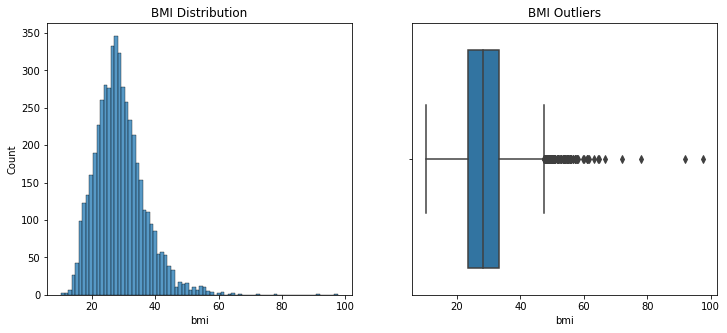

In [ ]:
col_distribution(data, 'bmi')

> We can observe that **there are many outliers values in this columns**, so we will need to:
    - fill nan values with median.
    - deal with these outliers.

In [ ]:
data = data.fillna({'bmi': data['bmi'].median()})

In [ ]:
data.isna().sum().sort_values(ascending=False)[:4]

id              0
gender          0
age             0
hypertension    0
dtype: int64

> <font color='blue'>**After filling the missing values, we can deal with outliers.**

In [ ]:
per_90 = np.percentile(data['bmi'], 90)
data['bmi'] = np.where(data['bmi']>per_90, per_90, data['bmi'])

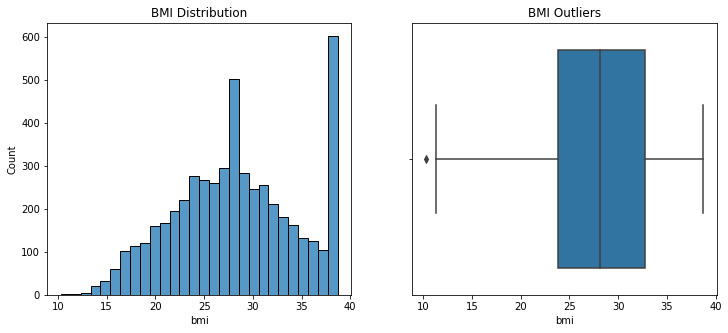

In [ ]:
col_distribution(data, 'bmi')

In [ ]:
per_10 = np.percentile(data['bmi'], 10)
data['bmi'] = np.where(data['bmi']<per_10, per_10, data['bmi'])

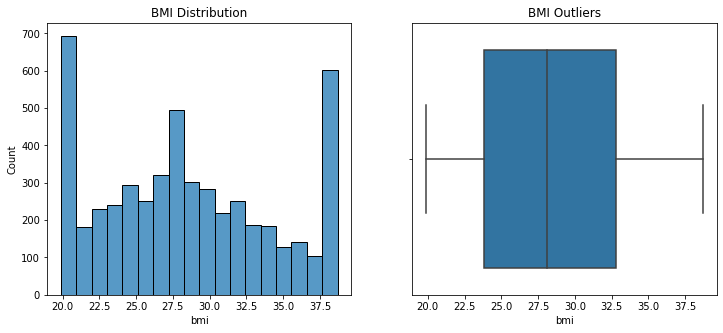

In [ ]:
col_distribution(data, 'bmi')

> <font color='green'>**Now we don't have outliers in this column.✅**</font>

I will check outliers in other columns.

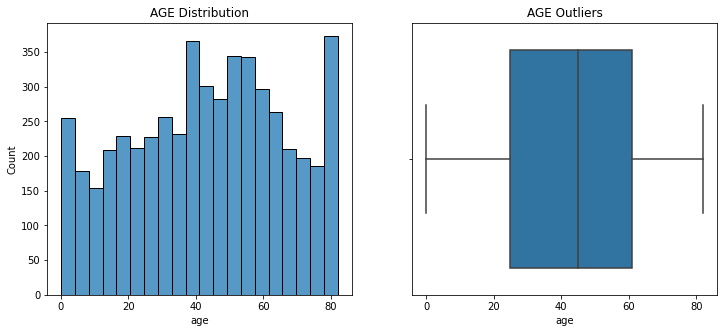

In [ ]:
col_distribution(data, 'age')

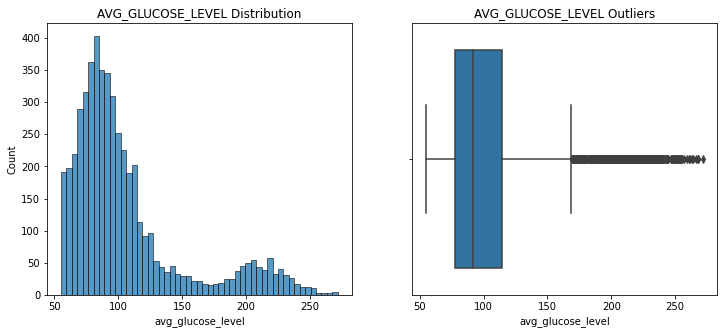

In [ ]:
col_distribution(data, 'avg_glucose_level')

> We can observe that we have outliers in this column which need to be cleaned.

In [ ]:
np.percentile(data['avg_glucose_level'], 85)

145.2565

In [ ]:
per_85 = np.percentile(data['avg_glucose_level'], 85)
data['avg_glucose_level'] = np.where(data['avg_glucose_level'] > per_85, per_85, data['avg_glucose_level'])

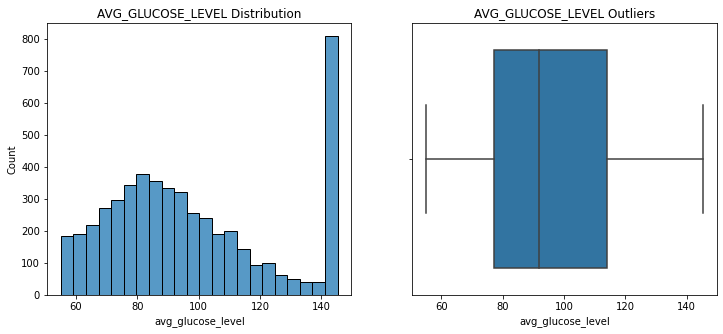

In [ ]:
col_distribution(data, 'avg_glucose_level')

`I choose to replace outliers with 85 percentitle because this is the begining of the outliers values and we can observe that from the first plot.`

> <font color='green'>**Now we don't have outliers in this column.✅**</font>


In [ ]:
data.columns[data.dtypes=='object'].tolist()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
obj_cols = data.columns[data.dtypes=='object'].tolist()
for i in obj_cols:
    print(f'{i}\n{data[i].value_counts()}')
    print('-------------------------')

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
-------------------------
ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64
-------------------------
work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
-------------------------
Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
-------------------------
smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
-------------------------


- In **gender column**, I will replace *other value* with the mode which is *female*.

In [ ]:
data[data['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [ ]:
data['gender'] = data['gender'].str.replace('Other', 'Female')

In [ ]:
data['gender'].value_counts()

Female    2995
Male      2115
Name: gender, dtype: int64

> We now need to **transform object data type to numeric** to be able to use them in machine learning algorithms.

In [ ]:
df = data.copy()
df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,145.2565,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,145.2565,28.1,never smoked,1


In [ ]:
obj_cols = df.select_dtypes(include='object').columns.tolist()
obj_cols

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
for i in obj_cols:
    df[i] = df[i].astype('category').cat.codes

In [ ]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,145.2565,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,145.2565,28.1,2,1
2,31112,1,80.0,0,1,1,2,0,105.9200,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,145.2565,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,145.2565,24.0,2,1


In [ ]:
show_defult_values(data)

,value,value_code
0,Female,0
1,Male,1
2,Yes,1
3,No,0
4,Private,2
5,Self-employed,3
6,children,4
7,Govt_job,0
8,Never_worked,1
9,Urban,1


> Now, **our data is ready for modeling**, *we just need to remove useless columns from data.*

In [ ]:
x = df.drop(columns=['stroke', 'id'])
model = pca(normalize=True)
out = model.fit_transform(x)

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [10] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [10] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[9]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


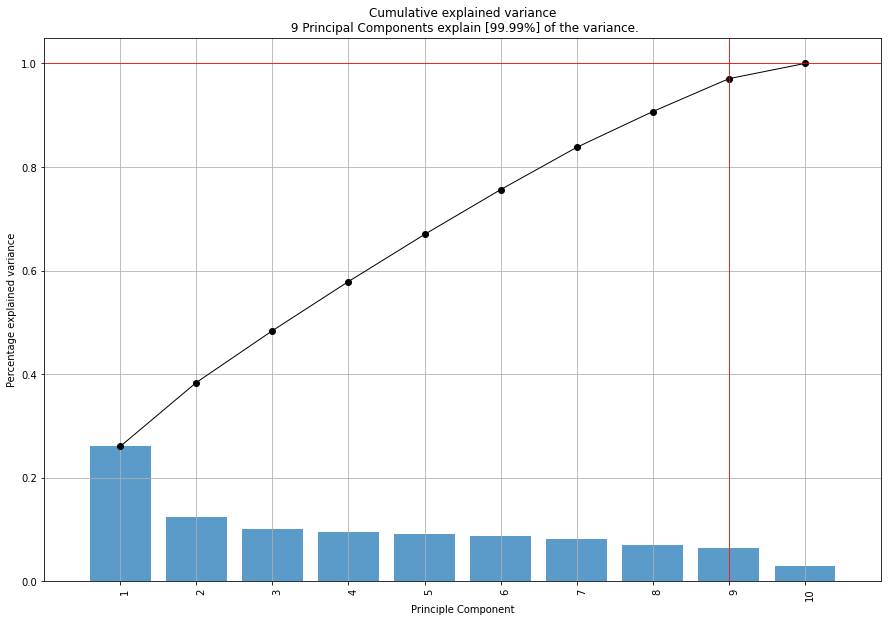

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, ax = model.plot()

[pca] >Plot PC1 vs PC2 with loadings.


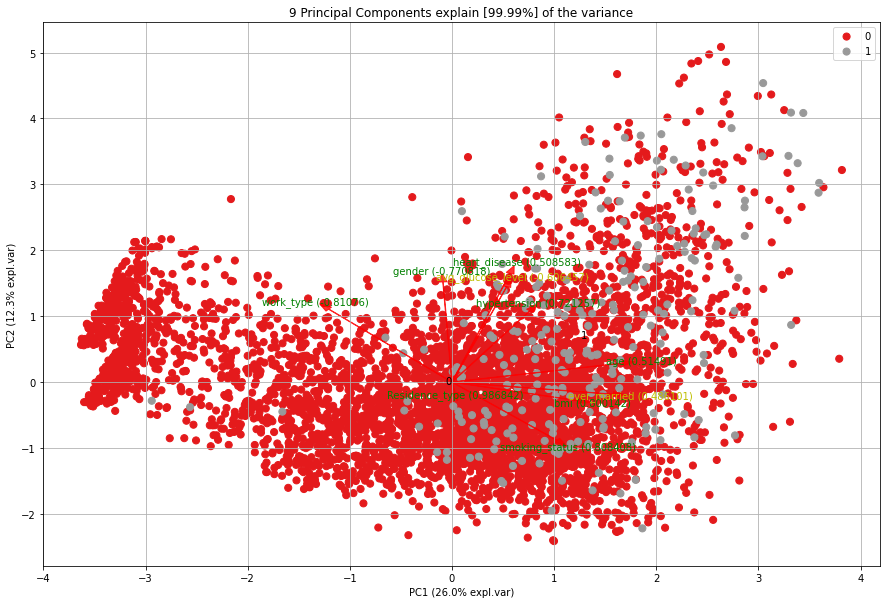

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc2299f5350>)

In [ ]:
model.biplot(y=df['stroke'])

#     

In [ ]:
x = df.drop(columns=['stroke', 'id', 'ever_married'])
model = pca(normalize=True)
out = model.fit_transform(x)

[pca] >Processing dataframe..
[pca] >Normalizing input data per feature (zero mean and unit variance)..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [9] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [9] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [9] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[9]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


In [ ]:
x.shape

(5110, 9)

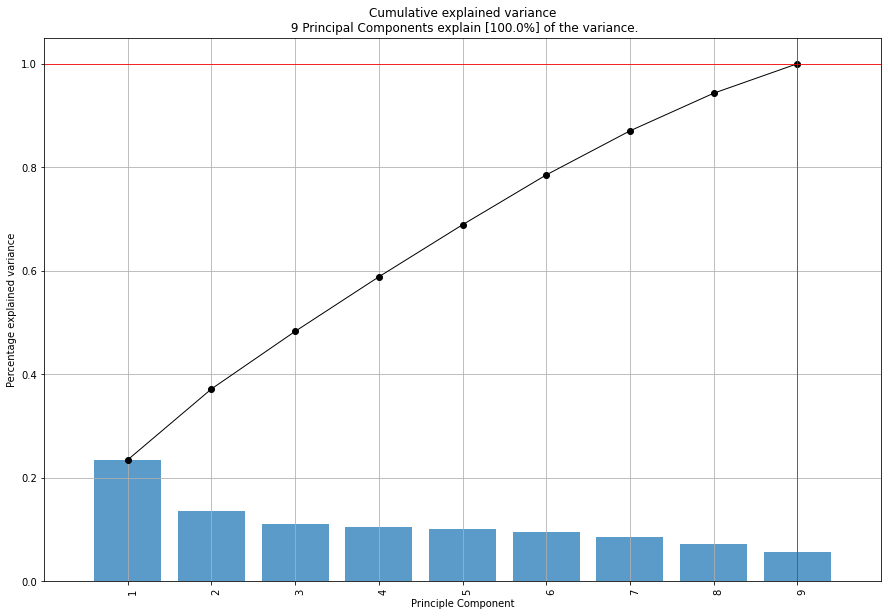

(<Figure size 1080x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fc229923210>)

<Figure size 432x288 with 0 Axes>

In [ ]:
model.plot()

In [ ]:
x = df.drop(columns = ['id', 'ever_married', 'stroke'])
y = df['stroke']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=42, test_size = 0.2, shuffle=True)

In [ ]:
len(x_train), len(x_test)

(4088, 1022)

#       

### Logistic Regression

In [ ]:
parameters = {'solver':['liblinear', 'sag'],
              'class_weight':['balanced', None],
              'C':[1,5,10]
             }

In [ ]:
grid_logistic = GridSearchCV(estimator=LogisticRegression(), param_grid=parameters, cv=5)
grid_logistic.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [1, 5, 10], 'class_weight': ['balanced', None],
                         'solver': ['liblinear', 'sag']})

In [ ]:
grid_logistic.best_params_

{'C': 1, 'class_weight': None, 'solver': 'liblinear'}

In [ ]:
grid_logistic.best_estimator_

LogisticRegression(C=1, solver='liblinear')

In [ ]:
grid_logistic.best_score_

0.9542565830622498

### KNN  

In [ ]:
parameters = {'n_neighbors':[3, 5, 7],
            'weights':['uniform', 'distance'],
           }
grid_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, cv=5)
grid_knn.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']})

In [ ]:
grid_knn.best_params_

{'n_neighbors': 7, 'weights': 'uniform'}

In [ ]:
grid_knn.best_score_

0.9498547072748111

><font color='blue'>For now, **the best accuracy comes from logistic regression algorithm (%95.42)**</font>

### Decision Tree

In [ ]:
parameters = {'max_depth':[50, 100, 150, 200, 300, 350, 400],
             'class_weight':[None, 'balanced']   
            }

grid_tree = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv=5)
grid_tree.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [50, 100, 150, 200, 300, 350, 400]})

In [ ]:
grid_tree.best_score_

0.9190317010471251

In [ ]:
grid_tree.best_params_

{'class_weight': 'balanced', 'max_depth': 200}

#          

### DummyClassifer

In [ ]:
parameters = {
    'strategy':['most_frequent', 'prior', 'stratified', 'uniform'],
}
grid_dummy = GridSearchCV(estimator=DummyClassifier(random_state=42), param_grid=parameters, cv=5)
grid_dummy.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=DummyClassifier(random_state=42),
             param_grid={'strategy': ['most_frequent', 'prior', 'stratified',
                                      'uniform']})

In [ ]:
grid_dummy.best_score_

0.9542565830622498

In [ ]:
grid_dummy.best_params_

{'strategy': 'most_frequent'}

#          

### Bagging & Boosting

In [ ]:
clf_bag = BaggingClassifier(base_estimator=grid_logistic.best_estimator_, n_estimators=7)
clf_bag.fit(x_train, y_train)

BaggingClassifier(base_estimator=LogisticRegression(C=1, solver='liblinear'),
                  n_estimators=7)

In [ ]:
clf_bag.score(x_train, y_train)

0.9542563600782779

In [ ]:
parameters = {'n_estimators':[77, 99, 151, 305, 409]
             }
grid_bag = GridSearchCV(estimator=BaggingClassifier(random_state=42, base_estimator=grid_logistic.best_estimator_), param_grid=parameters, cv=5)
grid_bag.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingClassifier(base_estimator=LogisticRegression(C=1,
                                                                           solver='liblinear'),
                                         random_state=42),
             param_grid={'n_estimators': [77, 99, 151, 305, 409]})

In [ ]:
grid_bag.best_score_

0.9542565830622498

In [ ]:
grid_bag.best_params_

{'n_estimators': 77}

##         

In [ ]:
parameters = {
    'n_estimators':[20, 50, 75, 100, 150],
    'learning_rate':[0.1, 0.5, 0.9, 1, 3, 5]
}
grid_boost = GridSearchCV(estimator=AdaBoostClassifier(random_state=42, base_estimator= grid_logistic.best_estimator_), param_grid=parameters, cv=5)
grid_boost.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=LogisticRegression(C=1,
                                                                            solver='liblinear'),
                                          random_state=42),
             param_grid={'learning_rate': [0.1, 0.5, 0.9, 1, 3, 5],
                         'n_estimators': [20, 50, 75, 100, 150]})

In [ ]:
grid_boost.best_score_

0.9542565830622498

In [ ]:
grid_boost.best_params_

{'learning_rate': 3, 'n_estimators': 75}

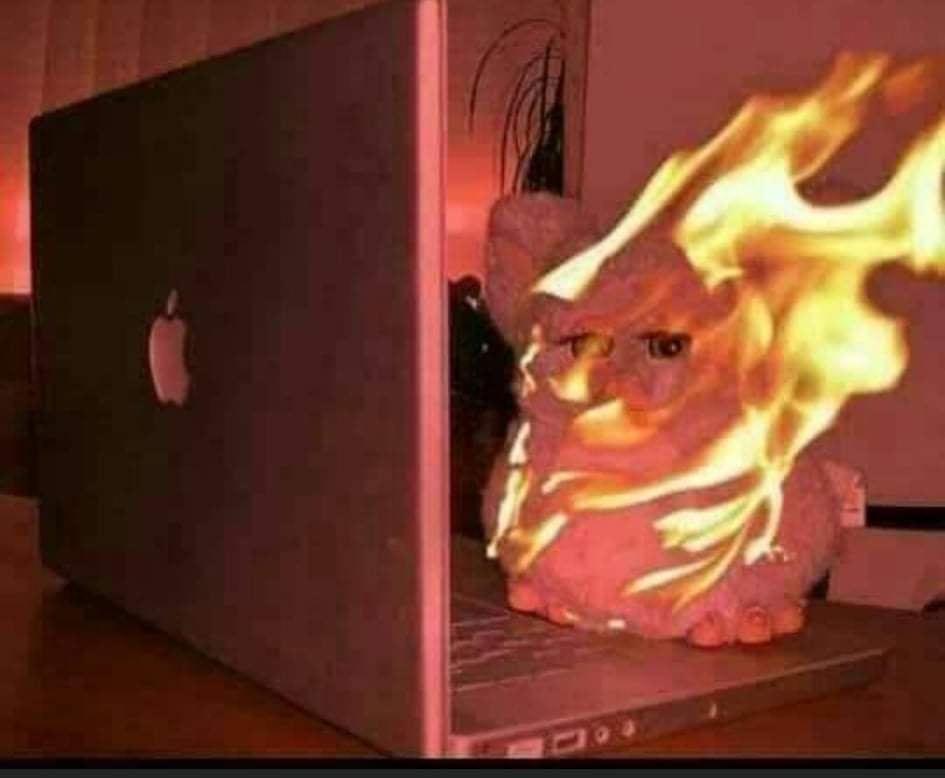

> <font color='brown'>As we can see, the accuracy is fixed, so Let's try another way to improve the accuracy. **I will build a simple deep neural network**.</font>

In [ ]:
model = keras.Sequential([
    # the hidden ReLU layers
    layers.Dense(units=4, activation='relu', input_shape=[9]),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=6, activation='relu'),
    # the linear output layer 
    layers.Dense(units=1),
])

In [ ]:
model.compile(optimizer='adam', metrics=['accuracy'], loss='mae')

In [ ]:
history = model.fit(
    x_train, y_train,
    batch_size=256,
    epochs=40,
)

Epoch 1/40
16/16 [==============================] - 1s 2ms/step - loss: 0.0460 - accuracy: 0.9543
Epoch 2/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9543
Epoch 3/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9543
Epoch 4/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9543
Epoch 5/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9543
Epoch 6/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9543
Epoch 7/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0459 - accuracy: 0.9543
Epoch 8/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9543
Epoch 9/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9543
Epoch 10/40
16/16 [==============================] - 0s 2ms/step - loss: 0.0458 - accuracy: 0.9543
Epoch 11/40
16/16 [

> <font color='blue'>we now make sure that the best accuracy is 95.4 which comes from LogisticRegression algorithm, and others algorithms like knn, decision tree and even simple neural network didn't make much different</font>

## Final Model

In [51]:
grid_logistic.best_estimator_

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [52]:
final_model = grid_logistic.best_estimator_
final_model.fit(x_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [59]:
print(f'The accuracy on training data : {round(final_model.score(x_train, y_train)*100, 2)} %')
print(f'The accuracy on test data : {round(final_model.score(x_test, y_test)*100, 2)} %')

The accuracy on training data : 95.43 %
The accuracy on test data : 93.93 %


In [60]:
# Lets save our model
with open('pickled_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)
    
print('Done')

Done


In [58]:
import joblib
joblib.dump(final_model, 'test_model.pkl')
print('Done')

Done


<h2><font color='brown'>Lets import model file and test it</font>

In [62]:
model = pickle.load(open('pickled_model.pkl', 'rb'))
model.predict(x_test)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [69]:
model.predict([[1,79,0,0,3,0,112,28,1]])

array([0], dtype=int64)

In [74]:
model.predict([[1,79,0,0,3,0,112,28,1]]).tolist()

[0]

In [68]:
x_train[:4]

,gender,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
802,1,79.0,0,0,3,0,112.64,28.5,1
3927,0,62.0,0,0,2,1,88.32,36.3,0
2337,0,21.0,0,0,2,0,59.52,33.7,2
3910,1,31.0,0,0,0,1,65.70,30.4,1
